## Objective:
 Generate a simple trading strategy based on the market returns and investors sentiment.

### Requirements
1. Dataset Preparation (assumed you have created a final_dataset.csv file as explained in the repo README section)


In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
# 1. Data Preparation

# provide path to the "final_dataset.csv"
data = pd.read_csv('/home/robin/work_root/git/twiced_official/bitcoin-sentiment-index/'
                   'data/02_processed/final_dataset.csv', index_col='Date')
# fill the marketcap with null value
data['MarketCap'] = data['MarketCap'].replace(np.NaN, data['MarketCap'].mean())

# Market Returns - Dependent Variable
y = data['MarketCap'].diff() / data['MarketCap'].shift(1)
y.rename('ret', inplace=True)

# Independent Variables
X = data.iloc[:, 2:]

#### Data Preprocessing

 Create a lag of 5 days sentiment measures - which means when we are going to study the sentiment impact on market return
 we are considering the past 5 days sentiment values.
 So we have 9 features which contributes to the sentiment - considering the past 5 days will give us 45 features
 for a single day time frame.
 Note: We will loose the first five days entry in the ML training.


In [6]:
# create a lag of 5 days
list_lags = []
for i in range(1, 6):
    X_lag = X.shift(i)
    for name in X.columns:
        X_lag.rename(columns={name: f"{name}({-i})"}, inplace=True)
    list_lags.append(X_lag)
    del X_lag

In [7]:
# Features - lagged values of sentiment measures
X_lagged = pd.concat(list_lags, axis=1)
X_lagged.dropna(inplace=True)
X_lagged.head() # X_lagged: {DataFrame: (2298,45)}
y = y.loc[X_lagged.index[0]:]

In [8]:
# split train & set data
X_train, X_test, y_train, y_test = train_test_split(X_lagged, y, shuffle=False)
y_test_num = y_test  # for later evaluation of VAR model (calculate MSFE)

## Random Forest Regressor



In [9]:
RANDOM_STATE = 42
rfr = RandomForestRegressor(n_estimators=500, random_state=RANDOM_STATE,
                            n_jobs=-1, max_features='sqrt')
rfr.fit(X_train, y_train)
y_fitted_rfr = rfr.predict(X_test)

# calculate MSFE of RF Regressor
error_rfr = y_fitted_rfr - y_test
mse_rfr = sum(error_rfr * error_rfr) / len(error_rfr)
print(f'MSFE Random Forest Regressor: {mse_rfr}')

MSFE Random Forest Regressor: 0.0015573319157677328


## Trading Signal
 BUY_t =
  \begin{cases}
    1      & \quad \text{if } RM_t \text{ $>$  0}\\
    -1     & \quad \text{if } RM_t \text{ $<$ 0}\\
    0  & \quad \text{Otherwise }
  \end{cases}
\

where $RM_t=(MarketCap_t - MarketCap_{t-1}) / MarketCap_t$

In [10]:
def sign_ret(num):
    """
    Convert predicted returns into trading signals
    Parameters
    ----------
    num : int
        Any number (in our case predicted returns)
    Returns
    -------
    int
        Trading signals, depends on the signs of predicted returns
        (1 is go long, -1 is go short, 0 is stay still)
    """
    if num > 0:
        return 1
    elif num < 0:
        return -1
    elif num == 0:
        return 0



##### Model Evaluation
We can  find the accuracy of the Random Forest Regressor model in predicting the trading signal.

Note: Our model fails in predicting '0' signals  as the return is always either positive or negative.
So we are not considering it in the evaluation.

In [16]:
def evaluate(y_test_fit, y_test_real):
    """

    Parameters
    ----------
    y_test_fit : Series
        y predicted using test data
    y_test_real : Series
        real y during the test period

    Returns
    -------
    Nonetype
        None

    """
    test_cm = confusion_matrix(y_test_real, y_test_fit)
    # for the sake we are not considering 'Zero signal case'
    cm_index = ['Negative', 'Positive']
    d_test_cm = pd.DataFrame(test_cm, columns=cm_index, index=cm_index)

    accuracy = ((d_test_cm.iloc[0][0] + d_test_cm.iloc[1][1]) / d_test_cm.sum().sum())

    print(f'Prediction Accuracy: {round(accuracy * 100, 2)}%.')
    print('--------')
    print('Confusion Matrix (Test Data):')

    print(d_test_cm)
    print('--------')
    return None


In [17]:
# Inorder to find the accuracy on Test data
# convert the predicted return to trading signals
y_fitted_rfr = pd.Series(y_fitted_rfr).apply(sign_ret)
# convert the  returns in test data  to trading signals
y_test = y_test.apply(sign_ret)

# In order to find the accuracy on Train data 0
# we do the same conversion on Training data
y_train_fit_rfr = pd.Series(rfr.predict(X_train)).apply(sign_ret)
y_train = y_train.apply(sign_ret)

print('Random Forest Regressor Performance:')
evaluate(y_fitted_rfr,y_test)

Random Forest Regressor Performance:
Prediction Accuracy: 61.39%.
--------
Confusion Matrix (Test Data):
          Negative  Positive
Negative       161       105
Positive       117       192
--------


### Random forest classifier


In [18]:
rfc = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE,
                             n_jobs=-1, max_features='sqrt')

rfc.fit(X_train, y_train)
y_fitted_rfc = pd.Series(rfc.predict(X_test))


#### Evaluate the Random forest classifier model



In [19]:
print('Random Forest Classifier Performance:')
evaluate(y_fitted_rfc,y_test)


Random Forest Classifier Performance:
Prediction Accuracy: 60.87%.
--------
Confusion Matrix (Test Data):
          Negative  Positive
Negative       171        95
Positive       130       179
--------


Lets see how the trading signal actually affect the bitcoin price :
Inorder to provide a causality, I have collected bitcoin price and the signals which we  have obtained in
the "test" data time frame ie. 21/09/2019 - 09/05/2021.
Please find the csv file under name "notebooks/Machine Learning/Bitcoin_Signal_test_data.csv"




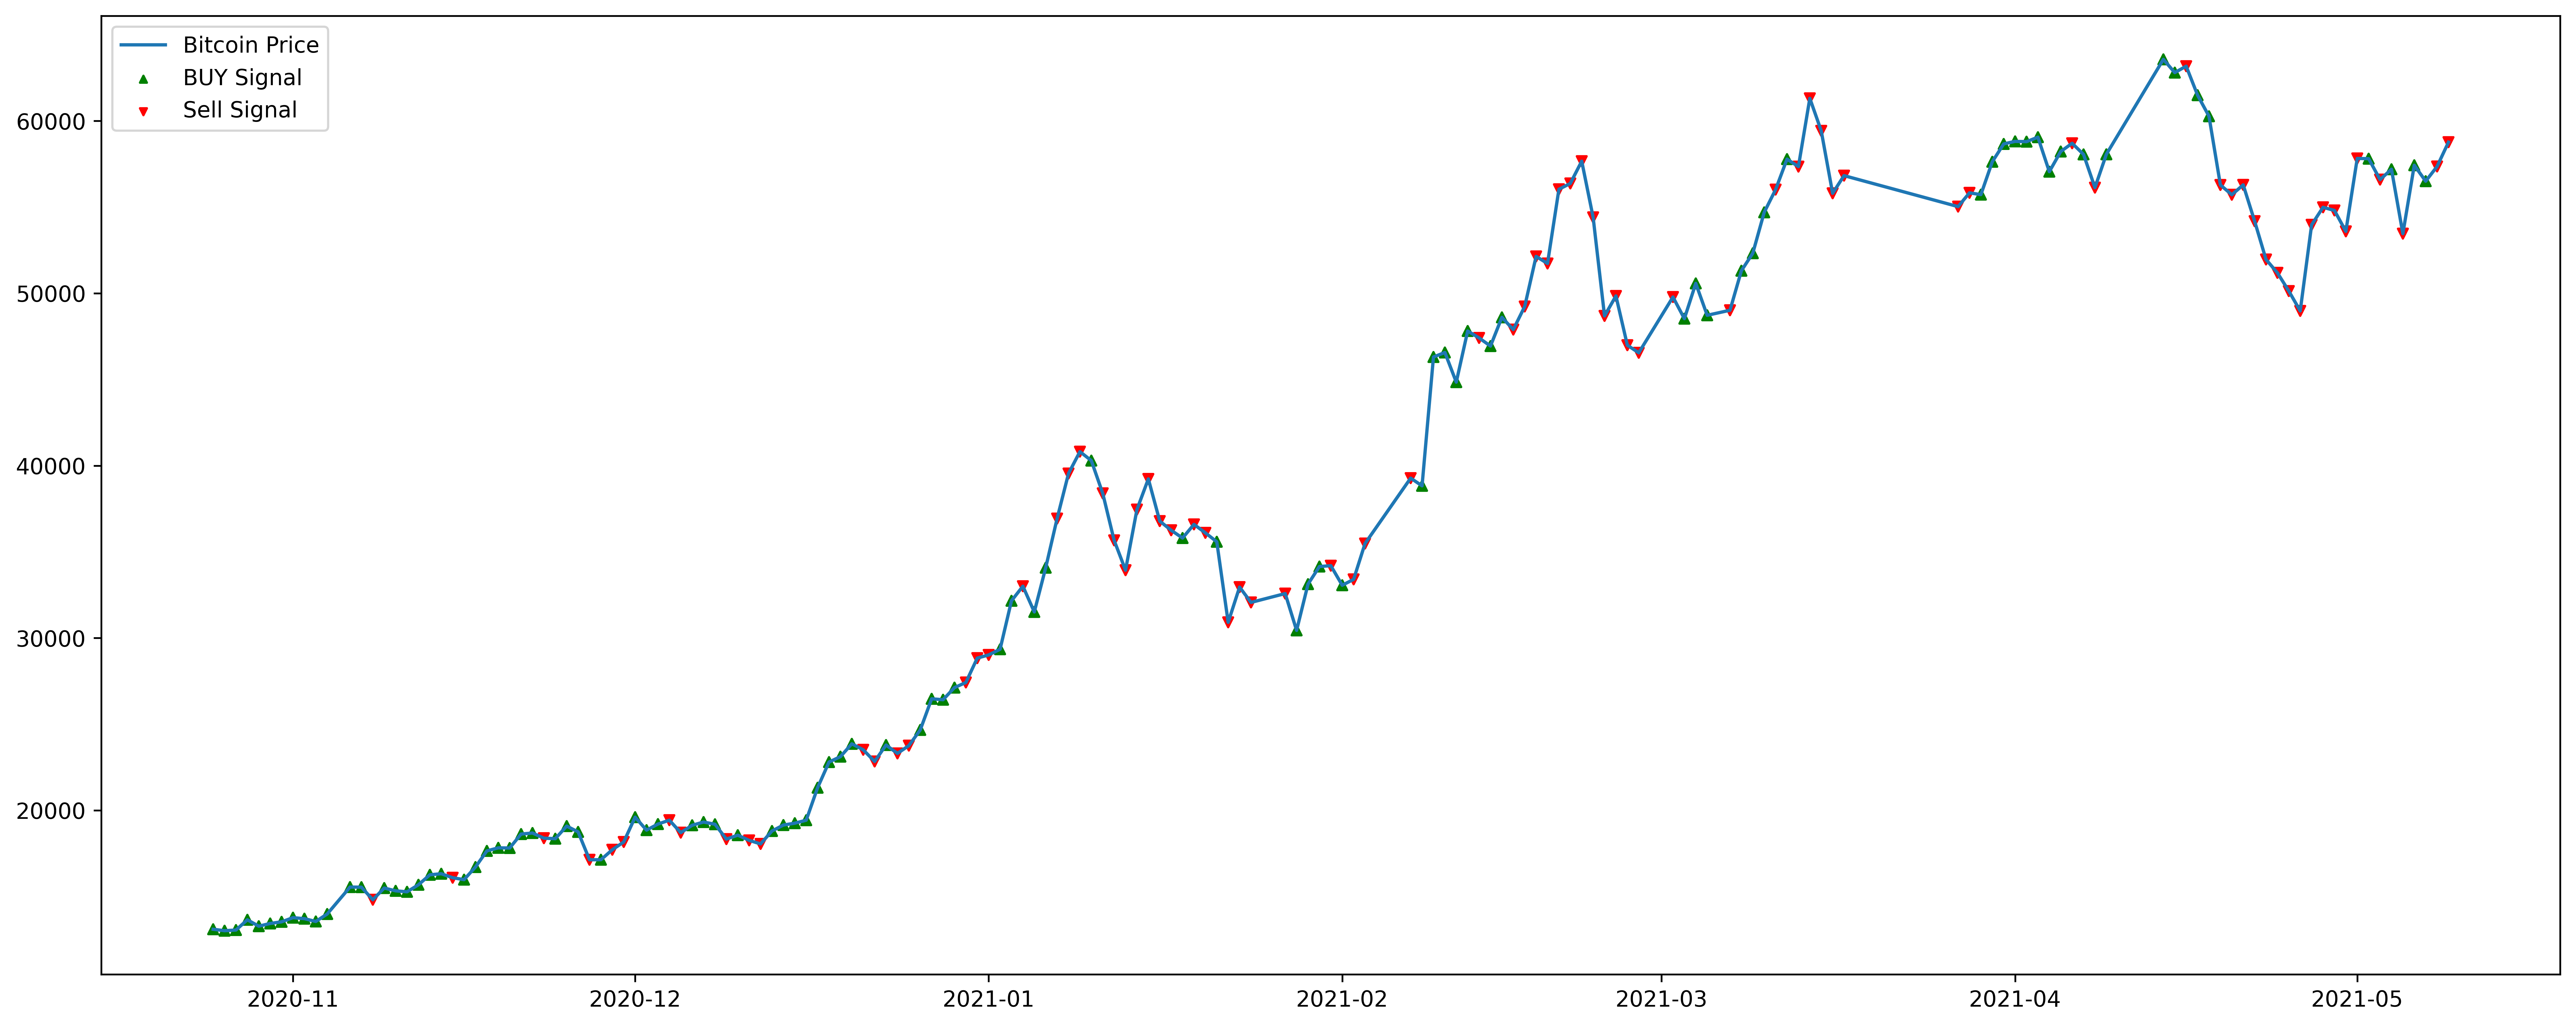

In [21]:
# plotting the bticoin vs trading signals

signal_price = pd.read_csv('Bitcoin_Signal_test_data.csv')
signal_price['Date'] = pd.to_datetime(signal_price.Date)
# considering a small time frame from the dataset
df2 = signal_price.loc[400:]
df2.set_index('Date', inplace=True)
#df2['BitcoinPrice'].plot()

fig = plt.figure(figsize=(20,8), dpi = 600,facecolor='w')

x = df2.index
y = df2['BitcoinPrice']
signal = df2['predicted signals']
a = plt.plot(x,y)

b = plt.scatter(x,y, marker='^',
             c='green',s=list(map(lambda a: 20 if a == 1 else 0, signal)))
c = plt.scatter(x,y, marker='v',
            c='red',s=list(map(lambda a: 20 if a == -1 else 0, signal)))


plt.legend([a[0],b,c],['Bitcoin Price','BUY Signal', 'Sell Signal'],
           loc = 'upper left')

plt.savefig('BitcoinPriceVsSignals.png')
plt.show()